In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip /content/drive/MyDrive/exercise2.zip > /dev/null

replace exercise2/data/devdata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!pip install transformers

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# from torch.optim import AdamW
from transformers import (
    BertModel, BertTokenizer, AutoModel, AutoTokenizer,
    AdamW, get_linear_schedule_with_warmup
    )
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
COLUMN_NAMES = ["sentiment", "aspect_category", "aspect_term", "position", "sentence"]
CATEGORY_NAMES = ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY',
                  'DRINKS#STYLE_OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY',
                  'FOOD#STYLE_OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL',
                  'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL']
NUM_CATEGORIES = 12
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 60
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
EPOCHS = 25
EMBEDDING_SIZE = 768 # 1024
TRAIN_SAMPLES = 1503
VALID_SAMPLES = 376

In [6]:
data_file = pd.read_csv("/content/exercise2/data/traindata.csv", delimiter="\t", 
                        names=COLUMN_NAMES, header=None)
data_file.head()

,sentiment,aspect_category,aspect_term,position,sentence
0,positive,AMBIENCE#GENERAL,seating,18:25,short and sweet – seating is great:it's romant...
1,positive,AMBIENCE#GENERAL,trattoria,25:34,This quaint and romantic trattoria is at the t...
2,positive,FOOD#QUALITY,food,98:102,The have over 100 different beers to offer thi...
3,negative,SERVICE#GENERAL,STAFF,5:10,THIS STAFF SHOULD BE FIRED.
4,positive,FOOD#STYLE_OPTIONS,menu,4:8,"The menu looked great, and the waiter was very..."


In [7]:
data_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        1503 non-null   object
 1   aspect_category  1503 non-null   object
 2   aspect_term      1503 non-null   object
 3   position         1503 non-null   object
 4   sentence         1503 non-null   object
dtypes: object(5)
memory usage: 58.8+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


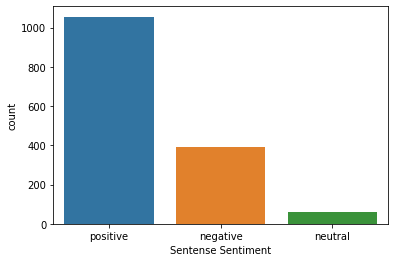

In [8]:
sns.countplot(data_file.sentiment)
plt.xlabel("Sentense Sentiment")
plt.show()

In [9]:
def generate_target_and_category(df):
    df["target"] = np.nan
    df.loc[df.sentiment == "positive", "target"] = 0
    df.loc[df.sentiment == "negative", "target"] = 1
    df.loc[df.sentiment == "neutral", "target"] = 2
    df_new = pd.get_dummies(df.aspect_category)
    existing_columns = set(df_new.columns)
    for column in CATEGORY_NAMES:
        if column in existing_columns:
            df[column] = df_new[column]
        else:
            df[column] = 0

    df["aspect_category"] = df["aspect_category"].str.lower().str.replace("#", "-")
    df["sentence"] = df["aspect_category"] + "-" + df["aspect_term"] + ": " + df["sentence"]


# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained("activebus/BERT_Review")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


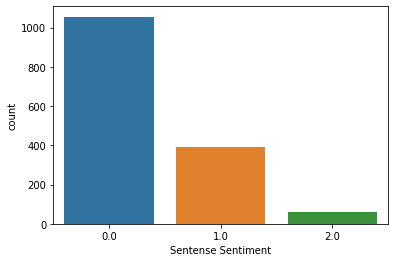

In [10]:
generate_target_and_category(data_file)
sns.countplot(data_file.target)
plt.xlabel("Sentense Sentiment")
plt.show()

In [11]:
data_file.aspect_category.value_counts()

food-quality                603
service-general             263
ambience-general            188
restaurant-general          138
food-style_options           98
food-prices                  58
drinks-quality               41
restaurant-miscellaneous     39
drinks-style_options         26
restaurant-prices            20
location-general             16
drinks-prices                13
Name: aspect_category, dtype: int64

In [12]:
print(np.sum(data_file["FOOD#QUALITY"]))
print(np.sum(data_file["RESTAURANT#GENERAL"]))
print(np.sum(data_file["LOCATION#GENERAL"]))

603
138
16


In [13]:
data_file["tokens"] = data_file.sentence.apply(lambda x: tokenizer.tokenize(x))
data_file

,sentiment,aspect_category,aspect_term,position,sentence,target,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE_OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE_OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL,tokens
0,positive,ambience-general,seating,18:25,ambience-general-seating: short and sweet – se...,0.0,1,0,0,0,0,0,0,0,0,0,0,0,"[am, ##bie, ##nce, -, general, -, seating, :, ..."
1,positive,ambience-general,trattoria,25:34,ambience-general-trattoria: This quaint and ro...,0.0,1,0,0,0,0,0,0,0,0,0,0,0,"[am, ##bie, ##nce, -, general, -, tr, ##att, #..."
2,positive,food-quality,food,98:102,food-quality-food: The have over 100 different...,0.0,0,0,0,0,0,1,0,0,0,0,0,0,"[food, -, quality, -, food, :, the, have, over..."
3,negative,service-general,STAFF,5:10,service-general-STAFF: THIS STAFF SHOULD BE FI...,1.0,0,0,0,0,0,0,0,0,0,0,0,1,"[service, -, general, -, staff, :, this, staff..."
4,positive,food-style_options,menu,4:8,food-style_options-menu: The menu looked great...,0.0,0,0,0,0,0,0,1,0,0,0,0,0,"[food, -, style, _, options, -, menu, :, the, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,positive,drinks-quality,expresso,29:37,drinks-quality-expresso: One of us actually li...,0.0,0,0,1,0,0,0,0,0,0,0,0,0,"[drinks, -, quality, -, express, ##o, :, one, ..."
1499,negative,service-general,waitress,20:28,service-general-waitress: The hostess and the ...,1.0,0,0,0,0,0,0,0,0,0,0,0,1,"[service, -, general, -, waitress, :, the, hos..."
1500,positive,restaurant-prices,place,12:17,restaurant-prices-place: this little place has...,0.0,0,0,0,0,0,0,0,0,0,0,1,0,"[restaurant, -, prices, -, place, :, this, lit..."
1501,positive,restaurant-general,restaurant,30:40,restaurant-general-restaurant: Nice Family own...,0.0,0,0,0,0,0,0,0,0,1,0,0,0,"[restaurant, -, general, -, restaurant, :, nic..."


In [14]:
data_file["token_ids"] = data_file.tokens.apply(lambda x: tokenizer.convert_tokens_to_ids(x))
data_file

,sentiment,aspect_category,aspect_term,position,sentence,target,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE_OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE_OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL,tokens,token_ids
0,positive,ambience-general,seating,18:25,ambience-general-seating: short and sweet – se...,0.0,1,0,0,0,0,0,0,0,0,0,0,0,"[am, ##bie, ##nce, -, general, -, seating, :, ...","[2572, 11283, 5897, 1011, 2236, 1011, 10747, 1..."
1,positive,ambience-general,trattoria,25:34,ambience-general-trattoria: This quaint and ro...,0.0,1,0,0,0,0,0,0,0,0,0,0,0,"[am, ##bie, ##nce, -, general, -, tr, ##att, #...","[2572, 11283, 5897, 1011, 2236, 1011, 19817, 1..."
2,positive,food-quality,food,98:102,food-quality-food: The have over 100 different...,0.0,0,0,0,0,0,1,0,0,0,0,0,0,"[food, -, quality, -, food, :, the, have, over...","[2833, 1011, 3737, 1011, 2833, 1024, 1996, 203..."
3,negative,service-general,STAFF,5:10,service-general-STAFF: THIS STAFF SHOULD BE FI...,1.0,0,0,0,0,0,0,0,0,0,0,0,1,"[service, -, general, -, staff, :, this, staff...","[2326, 1011, 2236, 1011, 3095, 1024, 2023, 309..."
4,positive,food-style_options,menu,4:8,food-style_options-menu: The menu looked great...,0.0,0,0,0,0,0,0,1,0,0,0,0,0,"[food, -, style, _, options, -, menu, :, the, ...","[2833, 1011, 2806, 1035, 7047, 1011, 12183, 10..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,positive,drinks-quality,expresso,29:37,drinks-quality-expresso: One of us actually li...,0.0,0,0,1,0,0,0,0,0,0,0,0,0,"[drinks, -, quality, -, express, ##o, :, one, ...","[8974, 1011, 3737, 1011, 4671, 2080, 1024, 202..."
1499,negative,service-general,waitress,20:28,service-general-waitress: The hostess and the ...,1.0,0,0,0,0,0,0,0,0,0,0,0,1,"[service, -, general, -, waitress, :, the, hos...","[2326, 1011, 2236, 1011, 13877, 1024, 1996, 22..."
1500,positive,restaurant-prices,place,12:17,restaurant-prices-place: this little place has...,0.0,0,0,0,0,0,0,0,0,0,0,1,0,"[restaurant, -, prices, -, place, :, this, lit...","[4825, 1011, 7597, 1011, 2173, 1024, 2023, 221..."
1501,positive,restaurant-general,restaurant,30:40,restaurant-general-restaurant: Nice Family own...,0.0,0,0,0,0,0,0,0,0,1,0,0,0,"[restaurant, -, general, -, restaurant, :, nic...","[4825, 1011, 2236, 1011, 4825, 1024, 3835, 215..."


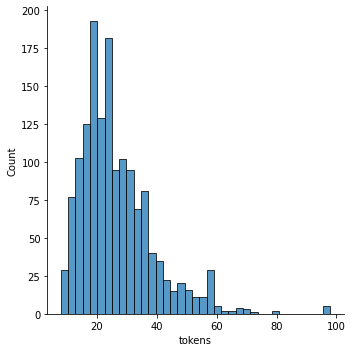

In [15]:
sns.displot(data_file.tokens.apply(lambda x: len(x)))
plt.show()

In [16]:
class MyDataset(Dataset):
    def __init__(self, data_frame, tokenizer, max_length):
        self._sentences = data_frame["sentence"]
        self._targets = torch.tensor(data_frame["target"], dtype=torch.long)
        self._category_dummies = data_frame[CATEGORY_NAMES].to_numpy()
        self._tokenizer = tokenizer
        self._max_length = max_length

    def __len__(self):
        return len(self._targets)

    def __getitem__(self, item):
        text = self._sentences[item]
        target = self._targets[item]
        category_dummies = self._category_dummies[item, :]
        encoded_text = tokenizer.encode_plus(
            text,
            return_tensors='pt',
            max_length=self._max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            )

        bert_dict = dict()
        bert_dict["category_dummies"] = category_dummies
        bert_dict["targets"] = target
        bert_dict["input_ids"] = encoded_text["input_ids"][0]
        bert_dict["attention_mask"] = encoded_text["attention_mask"][0]
        return bert_dict

In [17]:
train_file = pd.read_csv("/content/exercise2/data/traindata.csv", delimiter="\t",
                         names=COLUMN_NAMES, header=None)
valid_file = pd.read_csv("/content/exercise2/data/devdata.csv", delimiter="\t",
                         names=COLUMN_NAMES, header=None)
print(train_file.shape)
print(valid_file.shape)

(1503, 5)
(376, 5)


In [18]:
generate_target_and_category(train_file)
generate_target_and_category(valid_file)

print(train_file.shape)
print(valid_file.shape)

(1503, 18)
(376, 18)


In [19]:
train_dataset = MyDataset(
    data_frame=train_file,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataset = MyDataset(
    data_frame=valid_file,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH)

valid_dataloader = DataLoader(
    valid_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=2)

In [20]:
# sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

# encoding = tokenizer.encode_plus(
#     sample_txt,
#     return_tensors='pt',
#     max_length=60,
#     truncation=True,
#     padding='max_length',
#     add_special_tokens=True,
#     return_token_type_ids=False,
#     return_attention_mask=True,
# )

# encoding["attention_mask"].shape

In [21]:
# model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,
#                                   output_hidden_states=True)

# hidden_states = model(
#     input_ids=encoding['input_ids'],
#     attention_mask=encoding['attention_mask']
# ).hidden_states

In [22]:
# print ("Number of layers:", len(hidden_states))
# layer_i = 0
# print ("Number of batches:", len(hidden_states[layer_i]))
# batch_i = 0
# print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
# token_i = 0
# print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

In [23]:
# num_batches = len(hidden_states[0])
# sentence_embedding = torch.zeros(num_batches, EMBEDDING_SIZE)
# for idx in range(num_batches):
#     num_tokens = torch.sum(encoding['attention_mask'][idx])
#     num_tokens = num_tokens.item()
#     for layer in hidden_states[-4:]:
#         layer_embedding = torch.sum(layer[idx, :num_tokens, :], dim=0)
#         sentence_embedding[idx, :] += layer_embedding

#     sentence_embedding[idx, :] /= (num_tokens * 4)

# print(sentence_embedding.shape)

In [24]:
# class SentimentClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(SentimentClassifier, self).__init__()
#         self.encoder = BertModel.from_pretrained(
#             PRE_TRAINED_MODEL_NAME, output_hidden_states=True)
#         self.drop1 = nn.Dropout(p=0.5)
#         self.fc1 = nn.Linear(EMBEDDING_SIZE+NUM_CATEGORIES, 300)
#         self.drop2 = nn.Dropout(p=0.5)
#         self.fc2 = nn.Linear(300, 150)
#         self.drop3 = nn.Dropout(p=0.5)
#         self.fc3 = nn.Linear(150+NUM_CATEGORIES, n_classes)

#     def forward(self, input_ids, attention_mask, category_dummies):
#         hidden_states = self.encoder(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#             ).hidden_states

#         num_batches = len(hidden_states[0])
#         sentence_embedding = torch.zeros(num_batches, EMBEDDING_SIZE)
#         sentence_embedding = sentence_embedding.to(device)
#         for idx in range(num_batches):
#             num_tokens = torch.sum(attention_mask[idx])
#             num_tokens = num_tokens.item()
#             for layer in hidden_states[-4:]:
#                 layer_embedding = torch.sum(layer[idx, :num_tokens, :], dim=0)
#                 sentence_embedding[idx, :] += layer_embedding

#             sentence_embedding[idx, :] /= (num_tokens * 4)

#         next_input = torch.cat((sentence_embedding, category_dummies), dim=1)
#         next_input = self.drop1(next_input)
#         next_input = self.fc1(next_input)
#         next_input = self.drop2(next_input)
#         next_input = self.fc2(next_input)
#         next_input = self.drop3(next_input)
#         next_input = torch.cat((next_input, category_dummies), dim=1)
#         output = self.fc3(next_input)
#         return output

In [25]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        # self.encoder = BertModel.from_pretrained(
        #     PRE_TRAINED_MODEL_NAME, output_hidden_states=True)
        self.encoder = AutoModel.from_pretrained(
            "activebus/BERT_Review", output_hidden_states=True)
        self.elu1 = nn.ELU()
        self.drop1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(EMBEDDING_SIZE+NUM_CATEGORIES, 300)
        self.elu2 = nn.ELU()
        self.drop2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(300, 150)
        self.elu3 = nn.ELU()
        self.drop3 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(150+NUM_CATEGORIES, n_classes)

    def forward(self, input_ids, attention_mask, category_dummies):
        hidden_states = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
            ).hidden_states

        num_batches = len(hidden_states[0])
        sentence_embedding = torch.zeros(num_batches, EMBEDDING_SIZE)
        sentence_embedding = sentence_embedding.to(device)
        for layer in hidden_states[-4:]:
            layer_embedding = torch.mean(layer, dim=1)  # sentence vector of the layer
            sentence_embedding += layer_embedding

        sentence_embedding /= 4  # average sentence vector
        next_input = torch.cat((sentence_embedding, category_dummies), dim=1)
        next_input = self.elu1(next_input)
        next_input = self.drop1(next_input)
        next_input = self.fc1(next_input)
        next_input = self.elu2(next_input)
        next_input = self.drop2(next_input)
        next_input = self.fc2(next_input)
        next_input = self.elu3(next_input)
        next_input = self.drop3(next_input)
        next_input = torch.cat((next_input, category_dummies), dim=1)
        output = self.fc3(next_input)
        return output

In [26]:
# data = next(iter(train_dataloader))
# print(data.keys())

# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)

# print(input_ids.shape)
# print(attention_mask.shape)

In [27]:
def plot_losses(train_loss, val_loss, train_acc, val_acc, nb_epochs):
    """
    Visualize the train and validation losses after each
    epoch over the training process.
    """
    plt.plot(range(1, nb_epochs+1), train_loss)
    plt.plot(range(1, nb_epochs+1), val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training and Validation Losses")
    plt.show()

    plt.plot(range(1, nb_epochs+1), train_acc)
    plt.plot(range(1, nb_epochs+1), val_acc)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Training and Validation Accuracies")
    plt.show()

In [28]:
def train_network(model, train_iterator, valid_iterator, 
                  optimizer, criterion, epochs, model_name):
    """
    Trains a model and validates it after each epoch. Subsequently,
    plots the train and validation loss and accuracy curves.
    """
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    valid_loss_min = np.Inf
    for epoch in range(1, epochs+1):
        model.train()
        if epoch == 1:
            for param in model.encoder.parameters():
                param.requires_grad = False
        # elif epoch == 9:
        #     for param in model.encoder.parameters():
        #         param.requires_grad = True

        train_loss = 0.0
        train_correct_predictions = 0
        for batch in train_iterator:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
            category_dummies = batch["category_dummies"].to(device)
            optimizer.zero_grad()
            output = model(input_ids, attention_mask, category_dummies)
            _, preds = torch.max(output, dim=1)

            train_correct_predictions += torch.sum(preds == targets)
            loss = criterion(output, targets)
            train_loss += loss.item()
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()

        model.eval()
        valid_loss = 0.0
        valid_correct_predictions = 0
        for batch in valid_iterator:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
            category_dummies = batch["category_dummies"].to(device)
            output = model(input_ids, attention_mask, category_dummies)
            _, preds = torch.max(output, dim=1)

            valid_correct_predictions += torch.sum(preds == targets)
            loss = criterion(output, targets)
            valid_loss += loss.item()

        # evaluation
        train_loss = train_loss / len(train_iterator)
        valid_loss = valid_loss / len(valid_iterator)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        train_accuracy = train_correct_predictions / TRAIN_SAMPLES
        valid_accuracy = valid_correct_predictions / VALID_SAMPLES
        train_accuracies.append(train_accuracy.item())
        valid_accuracies.append(valid_accuracy.item())

        print(f"Epoch: {epoch}. "\
              f"Training Loss: {train_loss:.6f}.  "\
              f"Validation_loss: {valid_loss:.6f}. "\
              f"Train accuracy: {train_accuracy:.2f}. "\
              f"Valid accuracy: {valid_accuracy:.2f}.")

        # saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f"Validation loss decreased ({valid_loss_min:.4f} --> "\
                  f"{valid_loss:.4f}). Saving model..")
            torch.save(model.state_dict(), f"{model_name}_{epoch}.pt")
            print("Model Saved")
            valid_loss_min = valid_loss

    plot_losses(
        train_losses, valid_losses, train_accuracies, valid_accuracies, epochs)

Some weights of the model checkpoint at activebus/BERT_Review were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the

Epoch: 1. Training Loss: 0.797633.  Validation_loss: 0.685942. Train accuracy: 0.70. Valid accuracy: 0.70.
Validation loss decreased (inf --> 0.6859). Saving model..
Model Saved
Epoch: 2. Training Loss: 0.655725.  Validation_loss: 0.604501. Train accuracy: 0.71. Valid accuracy: 0.71.
Validation loss decreased (0.6859 --> 0.6045). Saving model..
Model Saved
Epoch: 3. Training Loss: 0.569614.  Validation_loss: 0.517795. Train accuracy: 0.76. Valid accuracy: 0.78.
Validation loss decreased (0.6045 --> 0.5178). Saving model..
Model Saved
Epoch: 4. Training Loss: 0.493760.  Validation_loss: 0.441845. Train accuracy: 0.82. Valid accuracy: 0.87.
Validation loss decreased (0.5178 --> 0.4418). Saving model..
Model Saved
Epoch: 5. Training Loss: 0.432894.  Validation_loss: 0.401774. Train accuracy: 0.85. Valid accuracy: 0.88.
Validation loss decreased (0.4418 --> 0.4018). Saving model..
Model Saved
Epoch: 6. Training Loss: 0.394892.  Validation_loss: 0.379760. Train accuracy: 0.86. Valid accurac

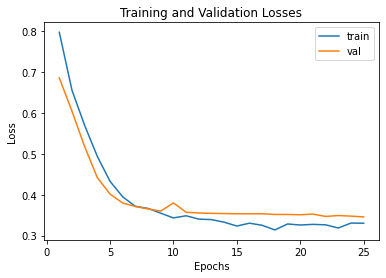

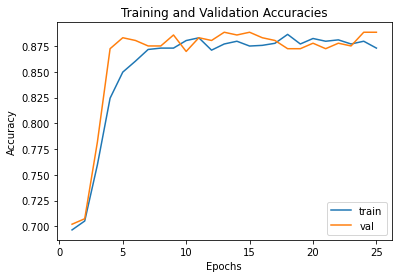

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(3)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss().to(device)
train_network(model, train_dataloader, valid_dataloader,
              optimizer, loss_function, EPOCHS, "bert")